<a href="https://colab.research.google.com/github/RFHertel/ESOF-4011/blob/main/Lab9_Transfer_Learning_Ensemble_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Transfer Learning / Averaging Ensemble ESOF 4011 Lab 9 Solution**

Lab Instructor: Robert Hertel

Note: Please share all links with me in the future by pressing share in the top right corner

Introduction Format:

Student Name: Robert Hertel

Sudent ID: XXXXXX

Lab No.: 9 

Colab link: https://colab.research.google.com/drive/1_RauwcPdLocTopvClDSReMfgFe46rJxT#scrollTo=Aid-1jcOerOH



# **Load the libraries**

In [ ]:
import tensorflow.keras as keras
print("Using Keras",keras.__version__)
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.optimizers import SGD
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import Model
from tensorflow.keras import layers
import os
import zipfile
import random
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
from tensorflow.keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image

%matplotlib inline

Using Keras 2.4.0


# **Preprocessing - Download and prepare the data**

Normalize the data: map each feature value from its current representation (an integer between 0
and 255) to a floating-point value between 0 and 1.0.

Store the floating-point values in x_train_normalized and x_test_normalized.

Map the class label to a on-hot-encoded value. Store in y_train_encoded and y_test_encoded.

In [ ]:
!wget --no-check-certificate \
    "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip" \
    -O "/tmp/cats-and-dogs.zip"

local_zip = '/tmp/cats-and-dogs.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()


--2021-04-05 16:32:03--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
Resolving download.microsoft.com (download.microsoft.com)... 80.67.92.138, 2a02:26f0:9b00:184::e59, 2a02:26f0:9b00:189::e59
Connecting to download.microsoft.com (download.microsoft.com)|80.67.92.138|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824894548 (787M) [application/octet-stream]
Saving to: ‘/tmp/cats-and-dogs.zip’

/tmp/cats-and-dogs. 100%[===================>] 786.68M   241MB/s    in 3.3s    

2021-04-05 16:32:06 (240 MB/s) - ‘/tmp/cats-and-dogs.zip’ saved [824894548/824894548]



In [ ]:
print(len(os.listdir('/tmp/PetImages/Cat/')))
print(len(os.listdir('/tmp/PetImages/Dog/')))

# Expected Output:
# 12501
# 12501

12501
12501


In [ ]:
# Use os.mkdir to create your directories
# You will need a directory for cats-v-dogs, and subdirectories for training
# and testing. These in turn will need subdirectories for 'cats' and 'dogs'
try:

  os.mkdir("/tmp/cats-v-dogs")
  os.mkdir("/tmp/cats-v-dogs/training")
  os.mkdir("/tmp/cats-v-dogs/testing")
  os.mkdir("/tmp/cats-v-dogs/training/cats")
  os.mkdir("/tmp/cats-v-dogs/training/dogs")
  os.mkdir("/tmp/cats-v-dogs/testing/cats")
  os.mkdir("/tmp/cats-v-dogs/testing/dogs")
  print("/tmp/cats-v-dogs")
  print("/tmp/cats-v-dogs/training")
  print("/tmp/cats-v-dogs/testing")
  print("/tmp/cats-v-dogs/training/cats")
  print("/tmp/cats-v-dogs/training/dogs")
  print("/tmp/cats-v-dogs/testing/cats")
  print("/tmp/cats-v-dogs/testing/dogs")
except OSError:
    print("error")


/tmp/cats-v-dogs
/tmp/cats-v-dogs/training
/tmp/cats-v-dogs/testing
/tmp/cats-v-dogs/training/cats
/tmp/cats-v-dogs/training/dogs
/tmp/cats-v-dogs/testing/cats
/tmp/cats-v-dogs/testing/dogs


Otherwise from example that's not mine use use:


In [ ]:
to_create = [
    '/tmp/cats-v-dogs',
    '/tmp/cats-v-dogs/training',
    '/tmp/cats-v-dogs/testing',
    '/tmp/cats-v-dogs/training/cats',
    '/tmp/cats-v-dogs/training/dogs',
    '/tmp/cats-v-dogs/testing/cats',
    '/tmp/cats-v-dogs/testing/dogs'
]

for directory in to_create:
    try:
        os.mkdir(directory)
        print(directory, 'created')
    except:
        print(directory, 'failed')

/tmp/cats-v-dogs failed
/tmp/cats-v-dogs/training failed
/tmp/cats-v-dogs/testing failed
/tmp/cats-v-dogs/training/cats failed
/tmp/cats-v-dogs/training/dogs failed
/tmp/cats-v-dogs/testing/cats failed
/tmp/cats-v-dogs/testing/dogs failed


The next need novel programming from you

In [ ]:
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    all_files_list = []
    
    for file_name in os.listdir(SOURCE):
        file_path = SOURCE + file_name

        if os.path.getsize(file_path):
            all_files_list.append(file_name)
        else:
            print('{} is zero length, so ignoring'.format(file_name))
    
    number_of_files = len(all_files_list)
    split_point = int(number_of_files * SPLIT_SIZE)
    blist = all_files_list[:split_point]
    shuffled = random.sample(blist, split_point)
    
    train_set = shuffled[:split_point]
    test_set = all_files_list[split_point:]
    
    for file_name in train_set:
        copyfile(SOURCE + file_name, TRAINING + file_name)
        
    for file_name in test_set:
        copyfile(SOURCE + file_name, TESTING + file_name)


CAT_SOURCE_DIR = "/tmp/PetImages/Cat/"
TRAINING_CATS_DIR = "/tmp/cats-v-dogs/training/cats/"
TESTING_CATS_DIR = "/tmp/cats-v-dogs/testing/cats/"
DOG_SOURCE_DIR = "/tmp/PetImages/Dog/"
TRAINING_DOGS_DIR = "/tmp/cats-v-dogs/training/dogs/"
TESTING_DOGS_DIR = "/tmp/cats-v-dogs/testing/dogs/"

split_size = .9
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, TESTING_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, TESTING_DOGS_DIR, split_size)

# Expected output
# 666.jpg is zero length, so ignoring
# 11702.jpg is zero length, so ignoring

666.jpg is zero length, so ignoring
11702.jpg is zero length, so ignoring


The previous needs novel info from you

In [ ]:
print(len(os.listdir('/tmp/cats-v-dogs/training/cats/')))
print(len(os.listdir('/tmp/cats-v-dogs/training/dogs/')))
print(len(os.listdir('/tmp/cats-v-dogs/testing/cats/')))
print(len(os.listdir('/tmp/cats-v-dogs/testing/dogs/')))

# Expected output:
# 11250
# 11250
# 1250
# 1250

11250
11250
1250
1250


In [ ]:
TRAINING_DIR = "/tmp/cats-v-dogs/training"
train_datagen = ImageDataGenerator( rescale = 1.0/255. ) 
train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=64,
                                                    class_mode='binary',
                                                    target_size=(224, 224))

VALIDATION_DIR = "/tmp/cats-v-dogs/testing"
validation_datagen = ImageDataGenerator( rescale = 1.0/255. ) 
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                         batch_size=64,
                                                         class_mode  = 'binary',
                                                         target_size = (224, 224))


Found 22498 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


# **Create deep neural net models for transfer learning**

Create a DenseNet and InceptionV3 architecture with the pretrained Imagenet weights

In [ ]:
def create_model_dense(input_dim_1=224, input_dim_2=224, input_dim_3 = 3, layer_soft_units=1):

  pre_trained_model = tf.keras.applications.DenseNet121(input_shape = (input_dim_1, input_dim_2, input_dim_3), 
                                include_top = True, 
                                weights = 'imagenet',
                                classes=1000)

  for layer in pre_trained_model.layers:
      layer.trainable = False
    
  for layer in pre_trained_model.layers:
      print(layer, layer.trainable)

  pre_trained_model = Model(pre_trained_model.input, pre_trained_model.layers[-2].output)

  last_layer = pre_trained_model.get_layer('avg_pool')
  print('last layer output shape: ', last_layer.output_shape)
  last_output = last_layer.output    
  x = layers.Dense(128, activation='relu')(last_output)
  x = layers.Dropout(0.1)(x)
  
  x = layers.Dense(layer_soft_units, activation='sigmoid')(x)
  model = Model( pre_trained_model.input, x) 
  model.summary()
  model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(), metrics=['accuracy'])
  return model

In [ ]:
model_DenseNet = create_model_dense()

33193984/33188688 [==============================] - 0s 0us/step
<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f103c7a6350> False
<tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x7f103c7dd0d0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f103c7f4ed0> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f103c812ed0> False
<tensorflow.python.keras.layers.core.Activation object at 0x7f103c7f9ad0> False
<tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x7f103c8114d0> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f103c811910> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f103c824250> False
<tensorflow.python.keras.layers.core.Activation object at 0x7f103c82a0d0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f103c834890> False
<tensorflow.python.keras.layers.normalization_v2.

In [ ]:
def create_model_inception(input_dim_1=224, input_dim_2=224, input_dim_3 = 3, layer_soft_units=1):

  pre_trained_model = InceptionV3(input_shape = (input_dim_1, input_dim_2, input_dim_3), 
                                include_top = False, 
                                weights = 'imagenet')


  for layer in pre_trained_model.layers:
    layer.trainable = False
  
  # pre_trained_model.summary() need this to use the stuff below

  last_layer = pre_trained_model.get_layer('mixed7')
  last_output = last_layer.output

  pre_trained_model = Model(pre_trained_model.input, pre_trained_model.layers[-2].output)

  last_layer = pre_trained_model.get_layer('mixed7')

  # Flatten the output layer to 1 dimension
  x = layers.Flatten()(last_output)
  # Add a fully connected layer with 1,024 hidden units and ReLU activation
  x = layers.Dense(1024, activation='relu')(x)
  # Add a dropout rate of 0.2
  x = layers.Dropout(0.2)(x)                  
  # Add a final sigmoid layer for classification
  x = layers.Dense(layer_soft_units, activation='sigmoid')(x)           

  model = Model( pre_trained_model.input, x) 

  model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(), metrics=['accuracy'])
  model.summary()
  return model

In [ ]:
model_inception = create_model_inception(input_dim_1=224, input_dim_2=224, input_dim_3 = 3, layer_soft_units=1)

87916544/87910968 [==============================] - 1s 0us/step
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
___________________________

# **Create a training funtion**

In [ ]:
def train_model(model, train_generator, validation_generator, epochs=100):
    history = model.fit(
      train_generator,
      epochs = epochs,
      validation_data= validation_generator, 
      verbose=2)
    
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='best')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='best')
    plt.show()



# **Evaluate the models** 

From this point go back and optomize them if not above 98%

Epoch 1/2


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

352/352 - 108s - loss: 0.0541 - accuracy: 0.9792 - val_loss: 0.0625 - val_accuracy: 0.9808
Epoch 2/2
352/352 - 84s - loss: 0.0340 - accuracy: 0.9865 - val_loss: 0.0336 - val_accuracy: 0.9896


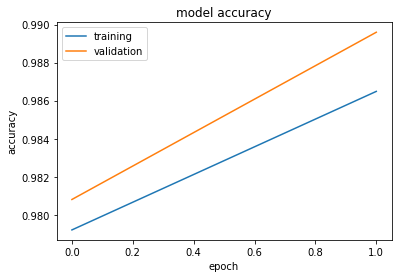

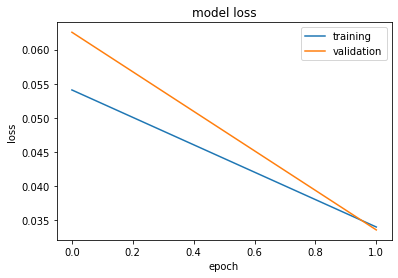

In [ ]:
train_model(model_DenseNet, train_generator, validation_generator, epochs=2)

Epoch 1/2


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

352/352 - 84s - loss: 0.2366 - accuracy: 0.9706 - val_loss: 0.0870 - val_accuracy: 0.9748
Epoch 2/2
352/352 - 79s - loss: 0.0214 - accuracy: 0.9930 - val_loss: 0.0932 - val_accuracy: 0.9824


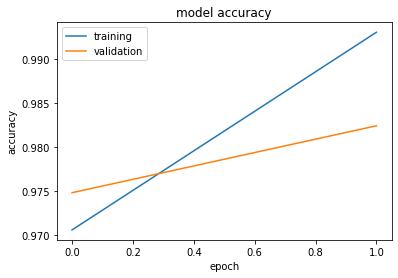

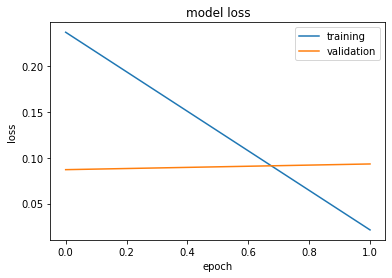

In [ ]:
train_model(model_inception, train_generator, validation_generator, epochs=2)

# **Create an ensemble model**

Make a simple averaging ensemble

In [ ]:
inputs = keras.Input(shape=(224,224,3))
y1 = model_DenseNet(inputs)
y2 = model_inception(inputs)
outputs = layers.average([y1, y2])
ensemble_model = keras.Model(inputs=inputs, outputs=outputs)

# **Predict with the ensemble**



In [ ]:
def load_image(img_path, show=False):

    img = image.load_img(img_path, target_size=(224, 224))
    img_tensor = image.img_to_array(img)                    # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    img_tensor /= 255.                                      # imshow expects values in the range [0, 1]

    if show:
        plt.imshow(img_tensor[0])                           
        plt.axis('off')
        plt.show()

    return img_tensor

In [ ]:
  # predicting images on images from the test folder. 1 for dog
  path = '/tmp/cats-v-dogs/testing/cats/10010.jpg' #More Examples: /tmp/cats-v-dogs/testing/cats/100.jpg, /tmp/cats-v-dogs/testing/dogs/100.jpg
  new_image = load_image(path)

  Final_Pred_Ensemble = ensemble_model.predict(new_image)
  print("Ensemble:",Final_Pred_Ensemble)
  Final_Pred_model_DenseNet = model_DenseNet.predict(new_image)
  print("DenseNet:",Final_Pred_model_DenseNet)
  Final_model_inception = model_inception.predict(new_image)
  print("inception:",Final_model_inception)

Ensemble: [[0.00061516]]
DenseNet: [[0.0010721]]
inception: [[0.00015822]]


**Clear model weights if want to rerun the algortihm**

In [ ]:
tf.keras.backend.clear_session()